**INTRODUCTION**

The dataset consists of estimated hourly power consumption in Megawatts (MW) from Duquesne Light Co. over 12 years (2006 - 2018).

In [268]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
from matplotlib import pyplot as plt
from prettytable import PrettyTable

from scipy.stats import spearmanr, boxcox
from scipy.special import inv_boxcox
from scipy import signal as sig

from numpy import fft

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from tqdm.notebook import tqdm_notebook

from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet import Prophet

plotly.offline.init_notebook_mode(connected=True)

**FUNCTIONS AND CONSTANTS**

In [269]:
def ts_plot(df, x, y, title="", xlabel='Date', ylabel='MW Consumotion', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(axis='x', alpha=0.75)
    plt.show();
    
def ts_hist(df, x, title="", xlabel="", ylabel='Frequency', dpi=100):
    x.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.grid(axis='y', alpha=0.75)
    plt.show();
    
def TS_Split(X, y, test_period="1y"):
    
        test_true = y.index >= (y.index.max() - pd.Timedelta(test_period))
        
        y_train = y.loc[~test_true]
        y_test = y.loc[test_true]
    
        X_train = X.loc[y_train.index]
        X_test = X.loc[y_test.index]
        
        return X_train, y_train, X_test, y_test

**DATASET PREPARATION**

In [270]:
df = pd.read_csv(r'C:\Users\1\Desktop\HW\DUQ_hourly.csv', parse_dates=['Datetime'])

In [271]:
df.head()

,Datetime,DUQ_MW
0,2005-12-31 01:00:00,1458.0
1,2005-12-31 02:00:00,1377.0
2,2005-12-31 03:00:00,1351.0
3,2005-12-31 04:00:00,1336.0
4,2005-12-31 05:00:00,1356.0


In [272]:
df.Datetime.duplicated().sum()

4

In [273]:
df = df.drop_duplicates(subset=['Datetime']).set_index('Datetime')

In [274]:
df.shape

(119064, 1)

In [275]:
df.isna().sum()

DUQ_MW    0
dtype: int64

**Check equal distancing**

In [276]:
df = df.sort_index()

In [277]:
df_index_diff = df.index.to_series().diff()
df_index_diff = df_index_diff.dt.total_seconds() // 60 // 60

Below we can see the values of hourly difference between an observation with the previous one. 

In [278]:
df_index_diff.value_counts()

1.0    119039
2.0        24
Name: Datetime, dtype: int64

In [279]:
df_index_diff[df_index_diff == 2.0]

Datetime
2005-04-03 04:00:00    2.0
2005-10-30 03:00:00    2.0
2006-04-02 04:00:00    2.0
2006-10-29 03:00:00    2.0
2007-03-11 04:00:00    2.0
2007-11-04 03:00:00    2.0
2008-03-09 04:00:00    2.0
2008-11-02 03:00:00    2.0
2009-03-08 04:00:00    2.0
2009-11-01 03:00:00    2.0
2010-03-14 04:00:00    2.0
2010-11-07 03:00:00    2.0
2010-12-10 01:00:00    2.0
2011-03-13 04:00:00    2.0
2011-11-06 03:00:00    2.0
2012-03-11 04:00:00    2.0
2012-11-04 03:00:00    2.0
2013-03-10 04:00:00    2.0
2013-11-03 03:00:00    2.0
2014-03-09 04:00:00    2.0
2015-03-08 04:00:00    2.0
2016-03-13 04:00:00    2.0
2017-03-12 04:00:00    2.0
2018-03-11 04:00:00    2.0
Name: Datetime, dtype: float64

Only 24 values are non-typical. We will resample the dataset by hours to create 24 missing indeces. Then we will fill the created NAs with the last available value. Since there're only such 24 observations, no big difference is created for the overall picture, but such imputations allow to proceed with the analysis.  

In [280]:
df_full = df.resample('h').fillna("pad")

**Extracting information from** `Datetime`

In [281]:
df_full['year'] = [d.year for d in df_full.index]
df_full['month'] = [d.month for d in df_full.index]
df_full['day'] = [d.day for d in df_full.index]
df_full['hour'] = [d.hour for d in df_full.index]

years = df_full['year'].unique()
months = df_full['month'].unique()
days = df_full['day'].unique()
hours = df_full['hour'].unique()

date_info = ['year', 'month', 'day', 'hour']

Now let's create cyclical features from the predictors.

In [282]:
df_full['month_sin'] = np.sin(df_full['month']*(2.*np.pi/12))
df_full['month_cos'] = np.cos(df_full['month']*(2.*np.pi/12))

df_full['day_sin'] = np.sin(df_full['day']*(2.*np.pi/30))
df_full['day_cos'] = np.cos(df_full['day']*(2.*np.pi/30))

df_full['hour_sin'] = np.sin(df_full['hour']*(2.*np.pi/24))
df_full['hour_cos'] = np.cos(df_full['hour']*(2.*np.pi/24))

In [283]:
df_full.head()

,DUQ_MW,year,month,day,hour,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
Datetime,,,,,,,,,,,
2005-01-01 01:00:00,1364.0,2005,1,1,1,0.5,0.866025,0.207912,0.978148,0.258819,0.965926
2005-01-01 02:00:00,1273.0,2005,1,1,2,0.5,0.866025,0.207912,0.978148,0.500000,0.866025
2005-01-01 03:00:00,1218.0,2005,1,1,3,0.5,0.866025,0.207912,0.978148,0.707107,0.707107
2005-01-01 04:00:00,1170.0,2005,1,1,4,0.5,0.866025,0.207912,0.978148,0.866025,0.500000
2005-01-01 05:00:00,1166.0,2005,1,1,5,0.5,0.866025,0.207912,0.978148,0.965926,0.258819


**PRELIMINARY VISUAL CHECK**

A transformation is performed over the target variable to compare the distributions. 

In [284]:
df_full['DUQ_MW_tr'], lmbda = boxcox(df_full.DUQ_MW)

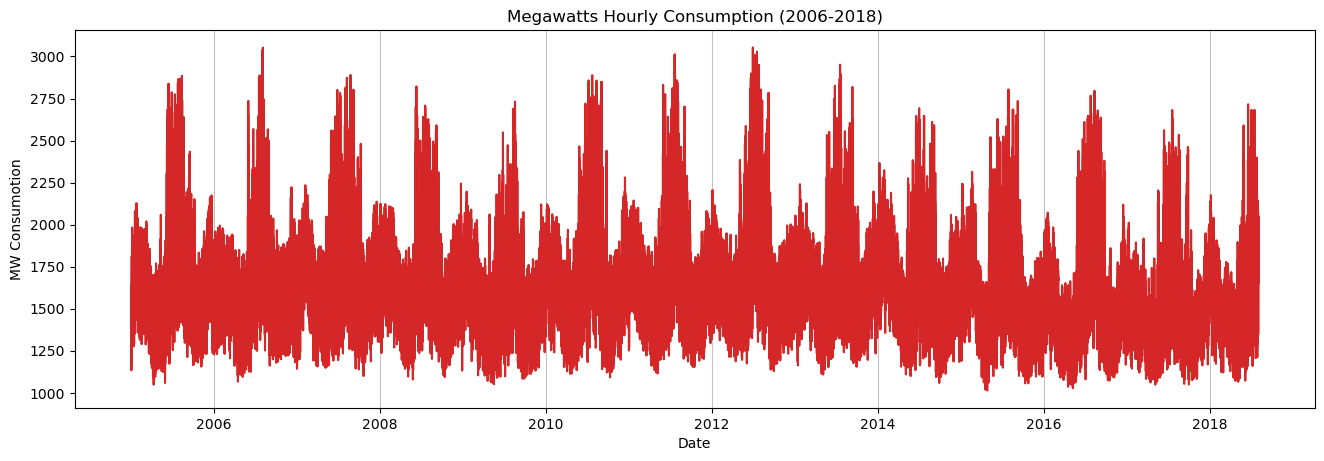

In [285]:
ts_plot(df=df_full, x = df_full.index, y=df_full.DUQ_MW, title = 'Megawatts Hourly Consumption (2006-2018)')

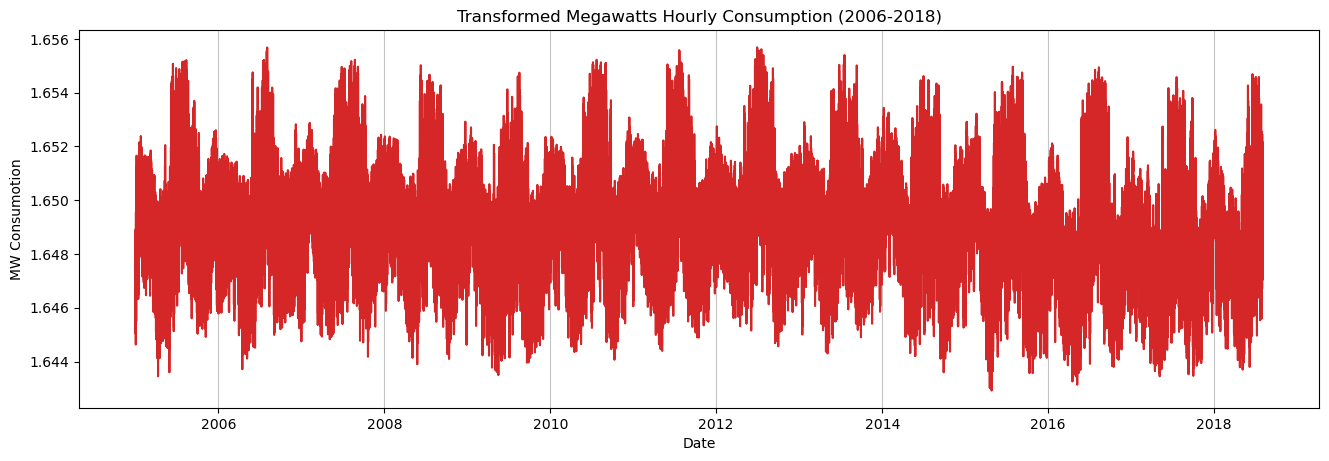

In [286]:
ts_plot(df=df_full, x = df_full.index, y=df_full.DUQ_MW_tr, title = 'Transformed Megawatts Hourly Consumption (2006-2018)')

For both plots, the data seems to be trend-stationary, i.e. it can be argued that no long-term trend is seen in the plot. There are signs of seasonality similar for every observed year. However, no significant shifts have occured during the period. 

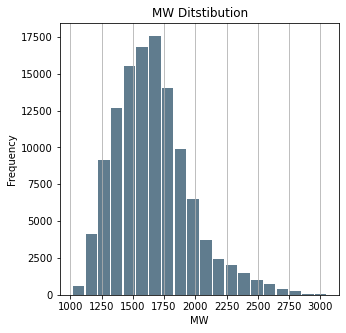

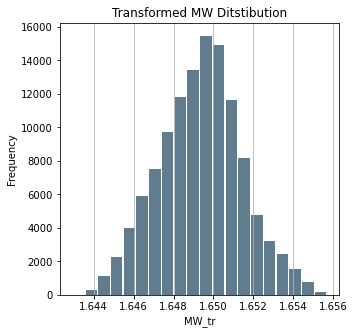

In [287]:
plt.rcParams.update({'figure.figsize': (5,5)})
ts_hist(df=df_full, x=df_full.DUQ_MW, xlabel='MW', title='MW Ditstibution')
ts_hist(df=df_full, x=df_full.DUQ_MW_tr, xlabel = 'MW_tr', title='Transformed MW Ditstibution')
plt.show()

The transformed target resembles Gaussian distribution. It will be used in the further analysis.

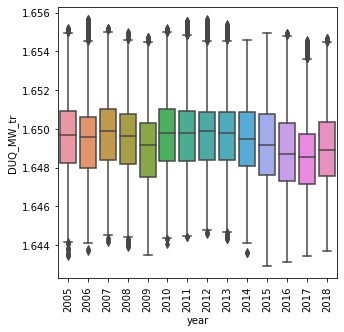

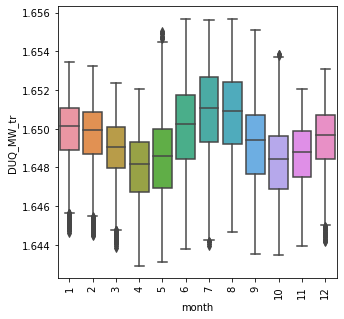

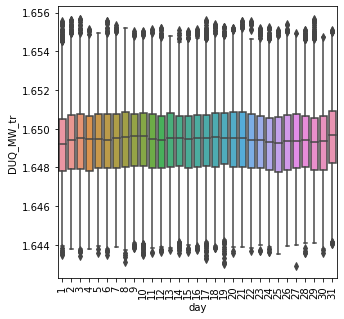

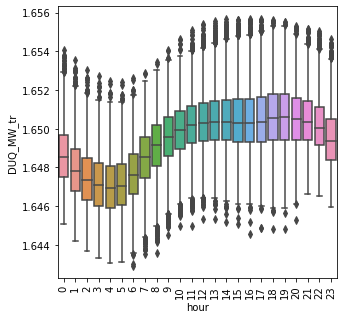

In [288]:
for i, col in enumerate(date_info):
    plt.figure(i)
    g = sns.boxplot(x=col, y='DUQ_MW_tr', data=df_full)
    g.set_xticklabels(g.get_xticklabels(), rotation=90);

By using boxplots, we can see the dynamics of energy consumption on different levels. There is a clear trend in the `month` and `hour` of consumption. It seems that people generally spend more electricity in summer as the temperature goes up (e.g. air-conditioning, swimming pools cleaning — all relevant to the USA market). The hourly dynamic can be explained with the fact that people consume less electricity at night. 

There are, however, no significant changes in electricity consumption across `year` and `day`.

Finally, to account for the year of observation, dummies are created.

In [289]:
df_full = pd.get_dummies(df_full, columns=['year'], drop_first=True, prefix='is')

**STATIONARITY TEST**

Augmented Dickey Fuller test:

In [290]:
adf_test = adfuller(df_full.DUQ_MW_tr.values, autolag='AIC')
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -17.91180788985276
p-value: 2.927673370107975e-30
Critial Values:
   1%, -3.4304049458984123
Critial Values:
   5%, -2.8615642852690217
Critial Values:
   10%, -2.5667829261914523


We reject the null hypothesis at all confidence levels. There is no unit root and the transformed data is stationary.

**Train / Test split**

Last year is used as the test period.

In [291]:
df_full.head()

,DUQ_MW,month,day,hour,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,...,is_2009,is_2010,is_2011,is_2012,is_2013,is_2014,is_2015,is_2016,is_2017,is_2018
Datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-01 01:00:00,1364.0,1,1,1,0.5,0.866025,0.207912,0.978148,0.258819,0.965926,...,0,0,0,0,0,0,0,0,0,0
2005-01-01 02:00:00,1273.0,1,1,2,0.5,0.866025,0.207912,0.978148,0.500000,0.866025,...,0,0,0,0,0,0,0,0,0,0
2005-01-01 03:00:00,1218.0,1,1,3,0.5,0.866025,0.207912,0.978148,0.707107,0.707107,...,0,0,0,0,0,0,0,0,0,0
2005-01-01 04:00:00,1170.0,1,1,4,0.5,0.866025,0.207912,0.978148,0.866025,0.500000,...,0,0,0,0,0,0,0,0,0,0
2005-01-01 05:00:00,1166.0,1,1,5,0.5,0.866025,0.207912,0.978148,0.965926,0.258819,...,0,0,0,0,0,0,0,0,0,0


In [292]:
df_full.index.max()

Timestamp('2018-08-03 00:00:00', freq='H')

In [293]:
X_train, y_train, X_test, y_test = TS_Split(
                                    df_full.drop(['DUQ_MW', 'DUQ_MW_tr'], axis=1), df_full['DUQ_MW_tr'])

<ipython-input-293-a6783f538c42>:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version



**FORECASTING WITH RAW DATA**

Simple Linear Regression

In [294]:
model_lin = LinearRegression()

In [295]:
model_lin.fit(X_train, y_train)

LinearRegression()

In [296]:
ts_cross_val = TimeSeriesSplit(n_splits=5)

In [297]:
cv = cross_val_score(model_lin, X_train, y_train, cv = ts_cross_val, scoring= "neg_mean_absolute_error")

In [298]:
cv

array([-0.00118152, -0.00130405, -0.00119115, -0.00132623, -0.00156154])

The score is, however, for the transformed target. It will be used later to compared the models. For this model, we will see the absolute value of the test score later.

In [299]:
y_pred = pd.Series(model_lin.predict(X_test))

In [300]:
y_pred.index = X_test.index

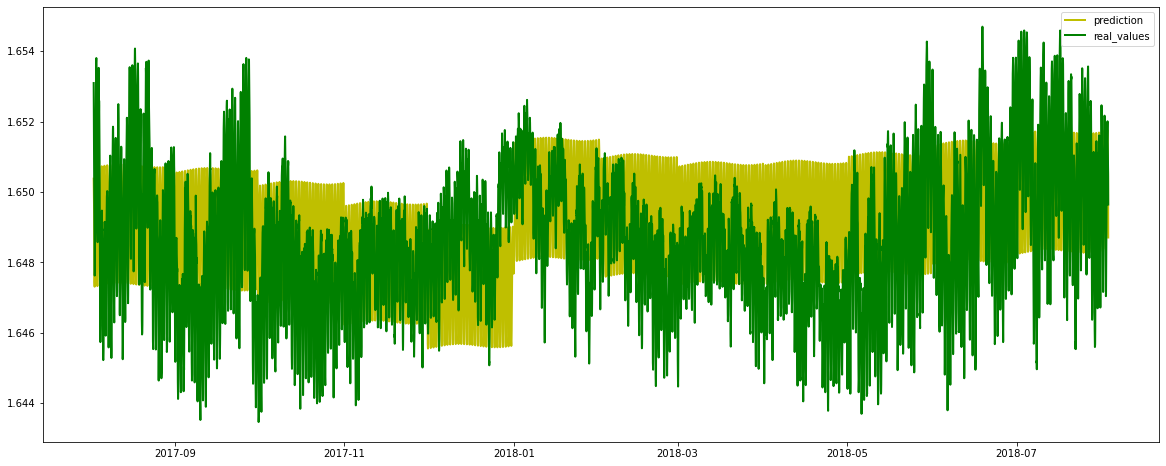

In [301]:
plt.figure(figsize=(20,8))
plt.plot(y_pred, "y", label="prediction", linewidth=2.0)
plt.plot(y_test, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

Generally, some of the trends are caputred. However, the prediction is limited and does not reflect the variance.

In [302]:
mean_absolute_error(inv_boxcox(y_test, lmbda), inv_boxcox(y_pred, lmbda))

174.66210244002792

The MAE for the test period is not that bad even with a simple linear regression! 

**DECOMPOSING THE TIME SERIES**

In [303]:
decomp_mult = seasonal_decompose(df_full['DUQ_MW_tr'], model='multiplicative')

In [304]:
decomp_add = seasonal_decompose(df_full['DUQ_MW_tr'], model='additive')

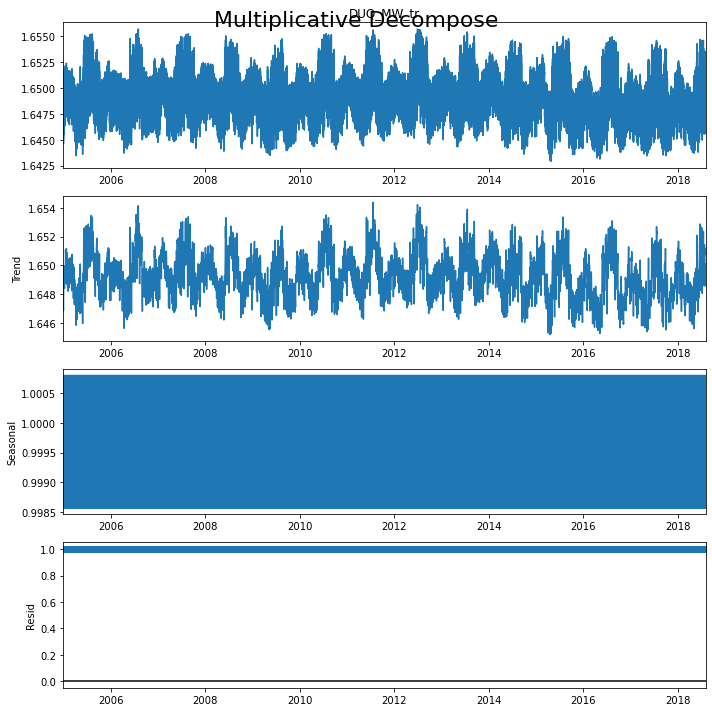

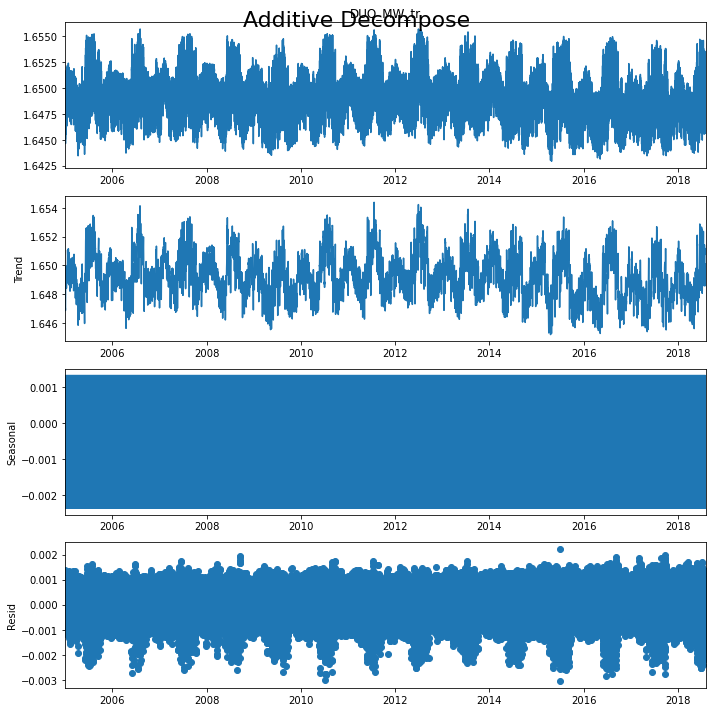

In [305]:
plt.rcParams.update({'figure.figsize': (10,10)})

decomp_mult.plot().suptitle('Multiplicative Decompose', fontsize=22)
decomp_add.plot().suptitle('Additive Decompose', fontsize=22)

plt.show()

It can be seen from the plots that there is no long-term trend as such. For the additive decomposition, the residuals seem to have patterns left (i.e. they don't look like white noise). This means that the decomposition is not perfect for the data. However, the multiplicative decomposition does not look any better so we will extract the components from the additive one. 

In [306]:
df_components = pd.concat([decomp_add.seasonal, decomp_add.trend], axis=1)
df_components.columns = ['season', 'trend']
df_components.head()

,season,trend
Datetime,,
2005-01-01 01:00:00,-0.001443,NaN
2005-01-01 02:00:00,-0.001924,NaN
2005-01-01 03:00:00,-0.002221,NaN
2005-01-01 04:00:00,-0.002363,NaN
2005-01-01 05:00:00,-0.002254,NaN


Let's add the extracted features to the model.

In [307]:
df_extracted = df_full.merge(df_components, how='left', on='Datetime').fillna(0)

In [308]:
df_extracted

,DUQ_MW,month,day,hour,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,...,is_2011,is_2012,is_2013,is_2014,is_2015,is_2016,is_2017,is_2018,season,trend
Datetime,,,,,,,,,,,,,,,,,,,,,
2005-01-01 01:00:00,1364.0,1,1,1,0.500000,0.866025,0.207912,0.978148,0.258819,0.965926,...,0,0,0,0,0,0,0,0,-0.001443,0.0
2005-01-01 02:00:00,1273.0,1,1,2,0.500000,0.866025,0.207912,0.978148,0.500000,0.866025,...,0,0,0,0,0,0,0,0,-0.001924,0.0
2005-01-01 03:00:00,1218.0,1,1,3,0.500000,0.866025,0.207912,0.978148,0.707107,0.707107,...,0,0,0,0,0,0,0,0,-0.002221,0.0
2005-01-01 04:00:00,1170.0,1,1,4,0.500000,0.866025,0.207912,0.978148,0.866025,0.500000,...,0,0,0,0,0,0,0,0,-0.002363,0.0
2005-01-01 05:00:00,1166.0,1,1,5,0.500000,0.866025,0.207912,0.978148,0.965926,0.258819,...,0,0,0,0,0,0,0,0,-0.002254,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,1966.0,8,2,20,-0.866025,-0.500000,0.406737,0.913545,-0.866025,0.500000,...,0,0,0,0,0,0,0,1,0.001188,0.0
2018-08-02 21:00:00,1944.0,8,2,21,-0.866025,-0.500000,0.406737,0.913545,-0.707107,0.707107,...,0,0,0,0,0,0,0,1,0.001102,0.0
2018-08-02 22:00:00,1901.0,8,2,22,-0.866025,-0.500000,0.406737,0.913545,-0.500000,0.866025,...,0,0,0,0,0,0,0,1,0.000816,0.0


**FORECASTING WITH TREND & SEASONALITY COMPONENTS**

In [309]:
X_train2, y_train2, X_test2, y_test2 = TS_Split(
                                    df_extracted.drop(['DUQ_MW', 'DUQ_MW_tr'], axis=1), df_extracted['DUQ_MW_tr'])

<ipython-input-309-9aa6a31bc55b>:1: FutureWarning:

Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version



In [310]:
model_lin = LinearRegression()

In [311]:
model_lin.fit(X_train2, y_train2)

LinearRegression()

In [312]:
ts_cross_val = TimeSeriesSplit(n_splits=5)

In [313]:
cv2 = cross_val_score(model_lin, X_train2, y_train2, cv = ts_cross_val, scoring= "neg_mean_absolute_error")

In [314]:
cv2

array([-0.00113553, -0.00125758, -0.00114392, -0.00129112, -0.00153252])

It can be said already that this model performes a bit better than the first one.

In [315]:
y_pred2 = pd.Series(model_lin.predict(X_test2))

In [316]:
y_pred2.index = X_test2.index

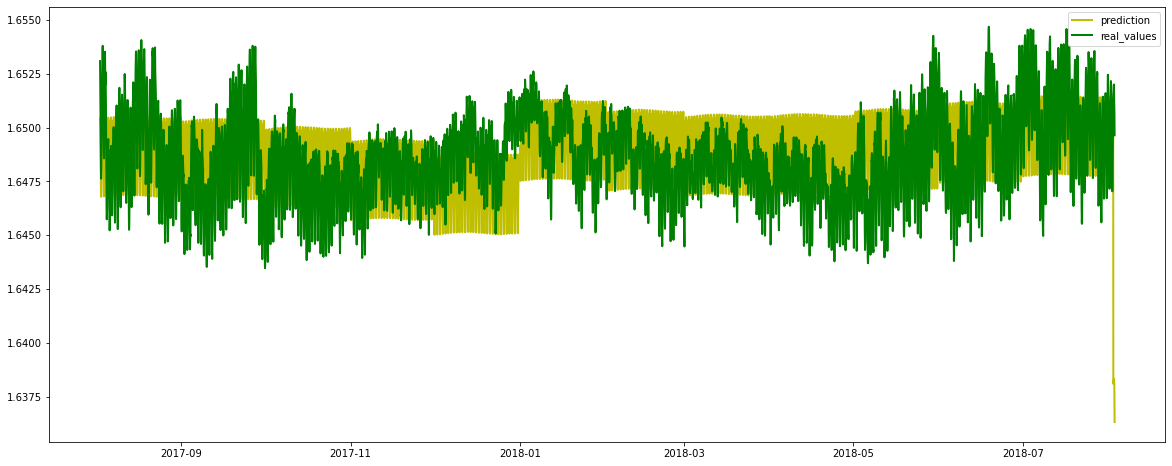

In [317]:
plt.figure(figsize=(20,8))
plt.plot(y_pred2, "y", label="prediction", linewidth=2.0)
plt.plot(y_test2, "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

The prediction exactly matches the real values, which means that there was likely a spill of information. 

In [318]:
mean_absolute_error(inv_boxcox(y_test2, lmbda), inv_boxcox(y_pred2, lmbda))

172.5363423381337

The score has not improved much. This might be since the decomposition performed did not capture the trend and seasonality well.